In [1]:
# ==================== 第1段: 导入库和数据准备 ====================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LassoCV
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, f1_score
from sklearn.preprocessing import label_binarize
from tabpfn_extensions import TabPFNClassifier
from tabpfn_extensions.rf_pfn import RandomForestTabPFNClassifier
import xgboost as xgb
import shap
import time
from collections import defaultdict
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, f1_score, precision_score
# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

def prepare_data():
    """数据准备函数"""
    # 读取数据
    df = pd.read_csv('resampled_data.csv')
    
    X = df.drop(columns=['category','attack', 'category', 'subcategory','stime','pkSeqID'])
    y = df.loc[:, 'category']
    
    # 对因变量进行编码
    le = LabelEncoder()
    y = le.fit_transform(y)
    
    # 分割数据
    X_train_full, X_test_full, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    print(f"训练集大小: {X_train_full.shape}")
    print(f"测试集大小: {X_test_full.shape}")
    print(f"特征总数: {X.shape[1]}")
    
    return X, y, X_train_full, X_test_full, y_train, y_test, le

# 执行数据准备
X, y, X_train_full, X_test_full, y_train, y_test, le = prepare_data()
results = defaultdict(dict)

训练集大小: (40427, 67)
测试集大小: (10107, 67)
特征总数: 67


In [2]:
# ==================== 第2段: 特征选择函数定义和执行 ====================
def lasso_feature_selection(X_train, y_train, alpha_range=None):
    """Lasso特征选择"""
    if alpha_range is None:
        alpha_range = np.logspace(-2.5, 0, 50)
        
    # 标准化
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_train)
    
    # Lasso CV
    lasso_cv = LassoCV(alphas=alpha_range, cv=5, random_state=42)
    lasso_cv.fit(X_scaled, y_train)
    
    # 获取最佳模型
    best_lasso = Lasso(alpha=0.026203985288583486, random_state=42)
    best_lasso.fit(X_scaled, y_train)
    
    # 选择特征
    lasso_importance = np.abs(best_lasso.coef_)
    selected_features = X_train.columns[lasso_importance > 0]
    
    print(f"Lasso选择的特征数: {len(selected_features)}")
    return selected_features, scaler, best_lasso

def rfe_feature_selection(X_train, y_train, n_features=30):
    """RFE特征选择"""
    # 标准化
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_train)
    
    # RFE
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    n_features_to_select = min(n_features, len(X_train.columns))
    
    rfe = RFE(estimator=rf, n_features_to_select=n_features_to_select, step=1)
    rfe.fit(X_scaled, y_train)
    
    selected_features = X_train.columns[rfe.support_]
    
    print(f"RFE选择的特征数: {len(selected_features)}")
    return selected_features, scaler, rfe

# 执行特征选择
print("=== 特征选择 ===")
lasso_features, lasso_scaler, lasso_model = lasso_feature_selection(X_train_full, y_train)
rfe_features, rfe_scaler, rfe_model = rfe_feature_selection(X_train_full, y_train)

# 计算特征交集
common_features = list(set(lasso_features).intersection(set(rfe_features)))
print(f"特征交集数: {len(common_features)}")

if len(common_features) == 0:
    print("警告: 没有交集特征，使用Lasso特征")
    final_features = lasso_features
else:
    final_features = common_features


=== 特征选择 ===
Lasso选择的特征数: 15
RFE选择的特征数: 30
特征交集数: 7


In [3]:
# ==================== 第3段: 模型评估函数定义 ====================
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """模型评估函数"""
    print(f"\n评估模型: {model_name}")
    
    # 训练时间
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    # 预测时间
    start_time = time.time()
    y_pred = model.predict(X_test)
    predict_time = time.time() - start_time
    
    # 计算指标
    accuracy = accuracy_score(y_test, y_pred)
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    macro_precision = precision_score(y_test, y_pred, average='macro')  # 主要指标
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # 计算AUC (多分类)
    try:
        if hasattr(model, 'predict_proba'):
            y_prob = model.predict_proba(X_test)
        elif hasattr(model, 'decision_function'):
            y_prob = model.decision_function(X_test)
        else:
            y_prob = None
            
        if y_prob is not None:
            # 二值化标签
            y_test_bin = label_binarize(y_test, classes=np.unique(y))
            n_classes = y_test_bin.shape[1]
            
            # 计算每类AUC
            fpr = dict()
            tpr = dict()
            roc_auc = dict()
            
            for i in range(n_classes):
                fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
                roc_auc[i] = auc(fpr[i], tpr[i])
            
            mean_auc = np.mean(list(roc_auc.values()))
        else:
            mean_auc = None
    except:
        mean_auc = None
    
    print(f"准确率: {accuracy:.4f}")
    print(f"Macro F1: {macro_f1:.4f}")
    print(f"Macro Precision: {macro_precision:.4f}")
    print(f"特征数: {X_train.shape[1]}")
    if mean_auc:
        print(f"平均AUC: {mean_auc:.4f}")
    print(f"训练时间: {train_time:.2f}秒")
    
    return {
        'model': model,
        'accuracy': accuracy,
        'macro_accuracy': macro_precision,  # 主要指标改为macro precision
        'macro_precision': macro_precision,
        'macro_f1': macro_f1,
        'confusion_matrix': conf_matrix,
        'train_time': train_time,
        'predict_time': predict_time,
        'mean_auc': mean_auc,
        'predictions': y_pred,
        'n_features': X_train.shape[1]
    }

print("模型评估函数已定义")

模型评估函数已定义


In [4]:
# ==================== 第4段: 实验组1 - 完整模型 ====================
def run_experiment_group_1():
    """Group 1: 完整模型 (Lasso + RFE + RF-TabPFN)"""
    print("\n=== Group 1: 完整模型 (Lasso + RFE + RF-TabPFN) ===")
    
    # 准备数据
    X_train_selected = X_train_full[final_features]
    X_test_selected = X_test_full[final_features]
    
    # TabPFN模型
    clf_base = TabPFNClassifier(
        ignore_pretraining_limits=True,
        inference_config={"SUBSAMPLE_SAMPLES": 10000}
    )
    
    tabpfn_tree_clf = RandomForestTabPFNClassifier(
        tabpfn=clf_base,
        verbose=0,
        max_predict_time=60
    )
    
    # 评估
    result = evaluate_model(
        tabpfn_tree_clf, X_train_selected, X_test_selected, 
        y_train, y_test, "Group1_Full"
    )
    
    results['group1'] = result
    results['group1']['features'] = final_features
    return result

# 执行实验组1
group1_result = run_experiment_group_1()



=== Group 1: 完整模型 (Lasso + RFE + RF-TabPFN) ===

评估模型: Group1_Full


c:\Users\qingfeng\anaconda3\envs\paper\lib\site-packages\tabpfn\classifier.py:421: UserWarning: Number of samples 32341 is greater than the maximum Number of samples 10000 supported by the model. You may see degraded performance.
  X, y, feature_names_in, n_features_in = validate_Xy_fit(
c:\Users\qingfeng\anaconda3\envs\paper\lib\site-packages\tabpfn\classifier.py:421: UserWarning: Number of samples 40427 is greater than the maximum Number of samples 10000 supported by the model. You may see degraded performance.
  X, y, feature_names_in, n_features_in = validate_Xy_fit(
c:\Users\qingfeng\anaconda3\envs\paper\lib\site-packages\tabpfn\classifier.py:421: UserWarning: Number of samples 32341 is greater than the maximum Number of samples 10000 supported by the model. You may see degraded performance.
  X, y, feature_names_in, n_features_in = validate_Xy_fit(
c:\Users\qingfeng\anaconda3\envs\paper\lib\site-packages\tabpfn\classifier.py:421: UserWarning: Number of samples 40427 is greater th

准确率: 0.9998
Macro F1: 0.9975
Macro Precision: 0.9975
特征数: 7
平均AUC: 1.0000
训练时间: 3.44秒


In [5]:

# ==================== 第5段: 实验组2 - 无特征筛选 ====================
def run_experiment_group_2():
    """Group 2: 无特征筛选 (原始特征 + RF-TabPFN)"""
    print("\n=== Group 2: 无特征筛选 (原始特征 + RF-TabPFN) ===")
    
    # 使用所有原始特征
    X_train_all = X_train_full
    X_test_all = X_test_full
    
    # TabPFN模型
    clf_base = TabPFNClassifier(
        ignore_pretraining_limits=True,
        inference_config={"SUBSAMPLE_SAMPLES": 10000}
    )
    
    tabpfn_tree_clf = RandomForestTabPFNClassifier(
        tabpfn=clf_base,
        verbose=0,
        max_predict_time=60
    )
    
    # 评估
    result = evaluate_model(
        tabpfn_tree_clf, X_train_all, X_test_all,
        y_train, y_test, "Group2_NoSelection"
    )
    
    results['group2'] = result
    results['group2']['features'] = list(X_train_full.columns)
    return result

# 执行实验组2
group2_result = run_experiment_group_2()


=== Group 2: 无特征筛选 (原始特征 + RF-TabPFN) ===

评估模型: Group2_NoSelection


c:\Users\qingfeng\anaconda3\envs\paper\lib\site-packages\tabpfn\classifier.py:421: UserWarning: Number of samples 32341 is greater than the maximum Number of samples 10000 supported by the model. You may see degraded performance.
  X, y, feature_names_in, n_features_in = validate_Xy_fit(
c:\Users\qingfeng\anaconda3\envs\paper\lib\site-packages\tabpfn\classifier.py:421: UserWarning: Number of samples 40427 is greater than the maximum Number of samples 10000 supported by the model. You may see degraded performance.
  X, y, feature_names_in, n_features_in = validate_Xy_fit(
c:\Users\qingfeng\anaconda3\envs\paper\lib\site-packages\tabpfn\classifier.py:421: UserWarning: Number of samples 40427 is greater than the maximum Number of samples 10000 supported by the model. You may see degraded performance.
  X, y, feature_names_in, n_features_in = validate_Xy_fit(


准确率: 0.9999
Macro F1: 0.9988
Macro Precision: 0.9977
特征数: 67
平均AUC: 1.0000
训练时间: 10.79秒


In [6]:

# ==================== 第6段: 实验组3 - 仅Lasso ====================
def run_experiment_group_3():
    """Group 3: 仅Lasso (Lasso筛选 + RF-TabPFN)"""
    print("\n=== Group 3: 仅Lasso (Lasso筛选 + RF-TabPFN) ===")
    
    # 准备数据
    X_train_lasso = X_train_full[lasso_features]
    X_test_lasso = X_test_full[lasso_features]
    
    # TabPFN模型
    clf_base = TabPFNClassifier(
        ignore_pretraining_limits=True,
        inference_config={"SUBSAMPLE_SAMPLES": 10000}
    )
    
    tabpfn_tree_clf = RandomForestTabPFNClassifier(
        tabpfn=clf_base,
        verbose=0,
        max_predict_time=60
    )
    
    # 评估
    result = evaluate_model(
        tabpfn_tree_clf, X_train_lasso, X_test_lasso,
        y_train, y_test, "Group3_LassoOnly"
    )
    
    results['group3'] = result
    results['group3']['features'] = list(lasso_features)
    return result

def run_experiment_group_4():
    """Group 4: 仅RFE (RFE筛选 + RF-TabPFN)"""
    print("\n=== Group 4: 仅RFE (RFE筛选 + RF-TabPFN) ===")
    
    # 准备数据
    X_train_rfe = X_train_full[rfe_features]
    X_test_rfe = X_test_full[rfe_features]
    
    # TabPFN模型
    clf_base = TabPFNClassifier(
        ignore_pretraining_limits=True,
        inference_config={"SUBSAMPLE_SAMPLES": 10000}
    )
    
    tabpfn_tree_clf = RandomForestTabPFNClassifier(
        tabpfn=clf_base,
        verbose=0,
        max_predict_time=60
    )
    
    # 评估
    result = evaluate_model(
        tabpfn_tree_clf, X_train_rfe, X_test_rfe,
        y_train, y_test, "Group4_RFEOnly"
    )
    
    results['group4'] = result
    results['group4']['features'] = list(rfe_features)
    return result

# 执行实验组3和4
group3_result = run_experiment_group_3()
group4_result = run_experiment_group_4()


=== Group 3: 仅Lasso (Lasso筛选 + RF-TabPFN) ===

评估模型: Group3_LassoOnly


c:\Users\qingfeng\anaconda3\envs\paper\lib\site-packages\tabpfn\classifier.py:421: UserWarning: Number of samples 32341 is greater than the maximum Number of samples 10000 supported by the model. You may see degraded performance.
  X, y, feature_names_in, n_features_in = validate_Xy_fit(
c:\Users\qingfeng\anaconda3\envs\paper\lib\site-packages\tabpfn\classifier.py:421: UserWarning: Number of samples 40427 is greater than the maximum Number of samples 10000 supported by the model. You may see degraded performance.
  X, y, feature_names_in, n_features_in = validate_Xy_fit(
c:\Users\qingfeng\anaconda3\envs\paper\lib\site-packages\tabpfn\classifier.py:421: UserWarning: Number of samples 32341 is greater than the maximum Number of samples 10000 supported by the model. You may see degraded performance.
  X, y, feature_names_in, n_features_in = validate_Xy_fit(
c:\Users\qingfeng\anaconda3\envs\paper\lib\site-packages\tabpfn\classifier.py:421: UserWarning: Number of samples 40427 is greater th

准确率: 0.9997
Macro F1: 0.9975
Macro Precision: 0.9954
特征数: 15
平均AUC: 1.0000
训练时间: 4.76秒

=== Group 4: 仅RFE (RFE筛选 + RF-TabPFN) ===

评估模型: Group4_RFEOnly


c:\Users\qingfeng\anaconda3\envs\paper\lib\site-packages\tabpfn\classifier.py:421: UserWarning: Number of samples 32341 is greater than the maximum Number of samples 10000 supported by the model. You may see degraded performance.
  X, y, feature_names_in, n_features_in = validate_Xy_fit(
c:\Users\qingfeng\anaconda3\envs\paper\lib\site-packages\tabpfn\classifier.py:421: UserWarning: Number of samples 40427 is greater than the maximum Number of samples 10000 supported by the model. You may see degraded performance.
  X, y, feature_names_in, n_features_in = validate_Xy_fit(
c:\Users\qingfeng\anaconda3\envs\paper\lib\site-packages\tabpfn\classifier.py:421: UserWarning: Number of samples 40427 is greater than the maximum Number of samples 10000 supported by the model. You may see degraded performance.
  X, y, feature_names_in, n_features_in = validate_Xy_fit(
c:\Users\qingfeng\anaconda3\envs\paper\lib\site-packages\tabpfn\classifier.py:421: UserWarning: Number of samples 32341 is greater th

准确率: 0.9997
Macro F1: 0.9975
Macro Precision: 0.9954
特征数: 30
平均AUC: 1.0000
训练时间: 8.46秒


In [7]:

# ==================== 第7段: 实验组5 - 单模型 ====================
def run_experiment_group_5():
    """Group 5: 单模型 (Lasso + RFE + 纯TabPFN)"""
    print("\n=== Group 5: 单模型 (Lasso + RFE + 纯TabPFN) ===")
    
    # 准备数据
    X_train_selected = X_train_full[final_features]
    X_test_selected = X_test_full[final_features]
    
    # 纯TabPFN模型（不使用RandomForest包装）
    tabpfn_clf = TabPFNClassifier(
        ignore_pretraining_limits=True,
        n_estimators=64,  
        inference_config={
            "SUBSAMPLE_SAMPLES": 12000

        },

    )
    
    # 评估
    result = evaluate_model(
        tabpfn_clf, X_train_selected, X_test_selected,
        y_train, y_test, "Group5_PureTabPFN"
    )
    
    results['group5'] = result
    results['group5']['features'] = final_features
    return result

# 执行实验组5
group5_result = run_experiment_group_5()


=== Group 5: 单模型 (Lasso + RFE + 纯TabPFN) ===

评估模型: Group5_PureTabPFN


c:\Users\qingfeng\anaconda3\envs\paper\lib\site-packages\tabpfn\classifier.py:421: UserWarning: Number of samples 40427 is greater than the maximum Number of samples 10000 supported by the model. You may see degraded performance.
  X, y, feature_names_in, n_features_in = validate_Xy_fit(


准确率: 0.9998
Macro F1: 0.9976
Macro Precision: 0.9954
特征数: 7
平均AUC: 1.0000
训练时间: 2.68秒


In [10]:
# ==================== 第8段: 实验组6 - Random Forest模型 ====================
def run_experiment_group_6():
    """Group 6: Random Forest模型 (Lasso + RFE + Random Forest)"""
    print("\n=== Group 6: Random Forest模型 (Lasso + RFE + Random Forest) ===")
    
    # 准备数据
    X_train_selected = X_train_full[final_features]
    X_test_selected = X_test_full[final_features]

    # Random Forest模型
    rf_clf = RandomForestClassifier(
        n_estimators=10, 
        max_depth=2, 
        min_samples_split=10, 
        random_state=42
    )
    
    # 评估
    result = evaluate_model(
        rf_clf, X_train_selected, X_test_selected,
        y_train, y_test, "Group6_RandomForest"
    )
    
    results['group6'] = result
    results['group6']['features'] = final_features
    return result

# 执行实验组6
group6_result = run_experiment_group_6()


=== Group 6: Random Forest模型 (Lasso + RFE + Random Forest) ===

评估模型: Group6_RandomForest
准确率: 0.9911
Macro F1: 0.7556
Macro Precision: 0.7915
特征数: 7
平均AUC: 0.9964
训练时间: 0.11秒


c:\Users\qingfeng\anaconda3\envs\paper\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



=== 绘制对比结果 ===


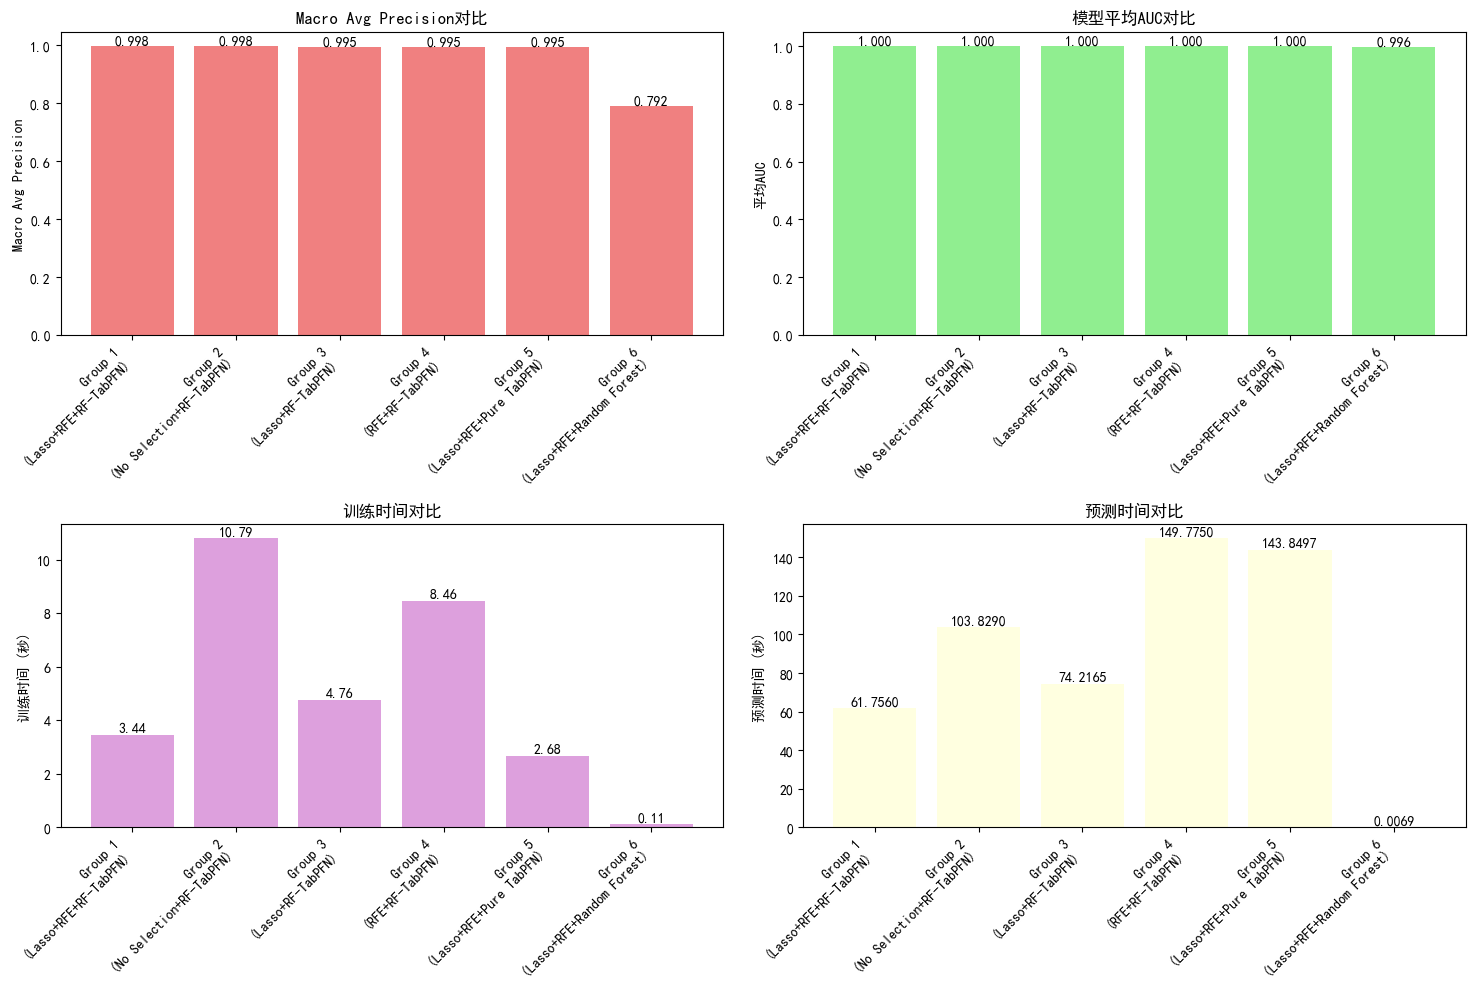


=== 生成结果汇总表 ===

=== 实验结果汇总 ===
                    实验组 Macro Avg Precision  平均AUC 训练时间(秒)  预测时间(秒)    准确率 Macro F1  特征数量
         Group 1 (完整模型)              0.9975 1.0000    3.44  61.7560 0.9998   0.9975     7
        Group 2 (无特征筛选)              0.9977 1.0000   10.79 103.8290 0.9999   0.9988    67
       Group 3 (仅Lasso)              0.9954 1.0000    4.76  74.2165 0.9997   0.9975    15
         Group 4 (仅RFE)              0.9954 1.0000    8.46 149.7750 0.9997   0.9975    30
          Group 5 (单模型)              0.9954 1.0000    2.68 143.8497 0.9998   0.9976     7
Group 6 (Random Forest)              0.7915 0.9964    0.11   0.0069 0.9911   0.7556     7

结果已保存到 '实验结果汇总.xlsx'

=== 所有实验完成 ===
实验组对比:
Group 1-5: 各种TabPFN配置
Group 6: Random Forest (传统机器学习)


In [11]:
# ==================== 第9段: 结果对比和汇总 ====================
def plot_comparison_results():
    """绘制对比结果"""
    print("\n=== 绘制对比结果 ===")
    
    # 准备数据
    groups = []
    macro_precisions = []
    aucs = []
    train_times = []
    predict_times = []
    
    group_names = {
        'group1': 'Group 1\n(Lasso+RFE+RF-TabPFN)',
        'group2': 'Group 2\n(No Selection+RF-TabPFN)',
        'group3': 'Group 3\n(Lasso+RF-TabPFN)',
        'group4': 'Group 4\n(RFE+RF-TabPFN)',
        'group5': 'Group 5\n(Lasso+RFE+Pure TabPFN)',
        'group6': 'Group 6\n(Lasso+RFE+Random Forest)'
    }
    
    for group_key, group_name in group_names.items():
        if group_key in results:
            result = results[group_key]
            groups.append(group_name)
            macro_precisions.append(result['macro_precision'])
            aucs.append(result['mean_auc'] if result['mean_auc'] else 0)
            train_times.append(result['train_time'])
            predict_times.append(result['predict_time'])
    
    # 创建子图 (2x2)
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Macro Precision对比
    axes[0, 0].bar(range(len(groups)), macro_precisions, color='lightcoral')
    axes[0, 0].set_title('Macro Avg Precision对比')
    axes[0, 0].set_ylabel('Macro Avg Precision')
    axes[0, 0].set_xticks(range(len(groups)))
    axes[0, 0].set_xticklabels(groups, rotation=45, ha='right')
    for i, v in enumerate(macro_precisions):
        axes[0, 0].text(i, v + 0.005, f'{v:.3f}', ha='center')
    
    # AUC对比
    axes[0, 1].bar(range(len(groups)), aucs, color='lightgreen')
    axes[0, 1].set_title('模型平均AUC对比')
    axes[0, 1].set_ylabel('平均AUC')
    axes[0, 1].set_xticks(range(len(groups)))
    axes[0, 1].set_xticklabels(groups, rotation=45, ha='right')
    for i, v in enumerate(aucs):
        if v > 0:
            axes[0, 1].text(i, v + 0.005, f'{v:.3f}', ha='center')
    
    # 训练时间对比
    axes[1, 0].bar(range(len(groups)), train_times, color='plum')
    axes[1, 0].set_title('训练时间对比')
    axes[1, 0].set_ylabel('训练时间 (秒)')
    axes[1, 0].set_xticks(range(len(groups)))
    axes[1, 0].set_xticklabels(groups, rotation=45, ha='right')
    for i, v in enumerate(train_times):
        axes[1, 0].text(i, v + max(train_times)*0.01, f'{v:.2f}', ha='center')
    
    # 预测时间对比
    axes[1, 1].bar(range(len(groups)), predict_times, color='lightyellow')
    axes[1, 1].set_title('预测时间对比')
    axes[1, 1].set_ylabel('预测时间 (秒)')
    axes[1, 1].set_xticks(range(len(groups)))
    axes[1, 1].set_xticklabels(groups, rotation=45, ha='right')
    for i, v in enumerate(predict_times):
        axes[1, 1].text(i, v + max(predict_times)*0.01, f'{v:.4f}', ha='center')
    
    plt.tight_layout()
    plt.savefig('六组实验对比结果.pdf', format='pdf', bbox_inches='tight')
    plt.show()

def generate_summary_table():
    """生成结果汇总表"""
    print("\n=== 生成结果汇总表 ===")
    
    summary_data = []
    group_names = {
        'group1': 'Group 1 (完整模型)',
        'group2': 'Group 2 (无特征筛选)',
        'group3': 'Group 3 (仅Lasso)',
        'group4': 'Group 4 (仅RFE)',
        'group5': 'Group 5 (单模型)',
        'group6': 'Group 6 (Random Forest)'
    }
    
    for group_key, group_name in group_names.items():
        if group_key in results:
            result = results[group_key]
            summary_data.append({
                '实验组': group_name,
                'Macro Avg Precision': f"{result['macro_precision']:.4f}",
                '平均AUC': f"{result['mean_auc']:.4f}" if result['mean_auc'] else "N/A",
                '训练时间(秒)': f"{result['train_time']:.2f}",
                '预测时间(秒)': f"{result['predict_time']:.4f}",
                '准确率': f"{result['accuracy']:.4f}",
                'Macro F1': f"{result['macro_f1']:.4f}",
                '特征数量': result['n_features']
            })
    
    summary_df = pd.DataFrame(summary_data)
    print("\n=== 实验结果汇总 ===")
    print(summary_df.to_string(index=False))
    
    # 保存到Excel
    summary_df.to_excel('实验结果汇总.xlsx', index=False)
    print("\n结果已保存到 '实验结果汇总.xlsx'")
    
    return summary_df

# 执行结果对比和汇总
plot_comparison_results()
summary = generate_summary_table()

print("\n=== 所有实验完成 ===")
print("实验组对比:")
print("Group 1-5: 各种TabPFN配置")
print("Group 6: Random Forest (传统机器学习)")